# Paper statistics

## netCDF distribution by aggregation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

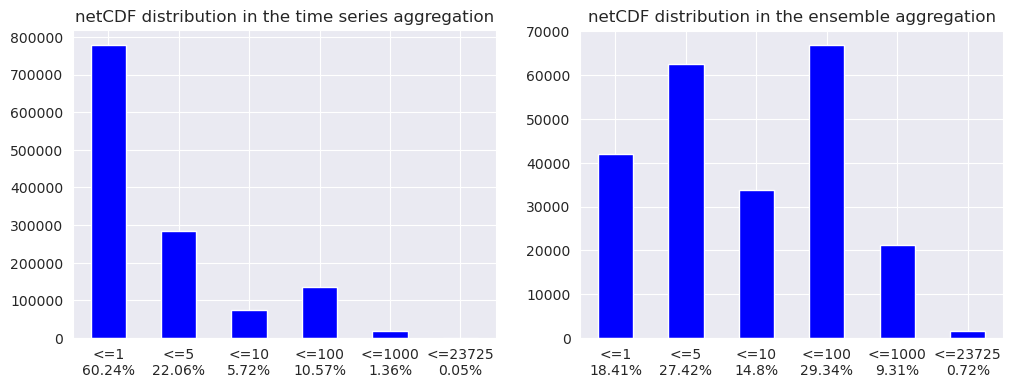

In [2]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,2, figsize=(12, 4))

    variable = pd.read_csv("variable_hist.csv", names=["name", "count"], skiprows=1)
    ensemble = pd.read_csv("ensemble_hist.csv", names=["name", "count"], skiprows=1)
    bins = [0, 1, 5, 10, 100, 1000, max(variable["count"].max(), ensemble["count"].max())]

    for data, axes in zip([variable, ensemble], ax):
        cuts = pd.cut(data["count"], bins=bins).value_counts(sort=False)
        cuts.plot.bar(rot=0, color="b", ax=axes)
        axes.set_xticklabels(["<={}\n{}%".format(c.right, round(v/len(data)*100,2)) for c,v in zip(cuts.index.categories, cuts.values)])

    ax[0].set_title("netCDF distribution in the time series aggregation")
    ax[1].set_title("netCDF distribution in the ensemble aggregation")

    plt.savefig("hist.png")

## Chunking times

In [3]:
import netCDF4
import timeit
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def test(dset):
    return dset[...].mean()

In [5]:
sizes = [256, 512, 1024, 2048, 4096, 8192]
results = []

for size in sizes:
    with netCDF4.Dataset("test.nc", "w") as f:
        f.createDimension("time", size)
        f.createVariable("time1", "f8", ("time",))
        f.createVariable("time2", "f8", ("time",), chunksizes=(1,))

        f["time1"][...] = list(range(size))
        f["time2"][...] = list(range(size))

    with netCDF4.Dataset("test.nc", "r") as f:
        results.append(timeit.timeit(lambda : test(f["time1"]), number=100))
        results.append(timeit.timeit(lambda : test(f["time2"]), number=100))

In [6]:
!ncdump -hs test.nc

netcdf test {
dimensions:
	time = 8192 ;
variables:
	double time1(time) ;
		time1:_Storage = "contiguous" ;
		time1:_Endianness = "little" ;
	double time2(time) ;
		time2:_Storage = "chunked" ;
		time2:_ChunkSizes = 1 ;
		time2:_Endianness = "little" ;

// global attributes:
		:_NCProperties = "version=2,netcdf=4.8.1,hdf5=1.12.2" ;
		:_SuperblockVersion = 2 ;
		:_IsNetcdf4 = 1 ;
		:_Format = "netCDF-4" ;
}


In [7]:
results

[0.06343342736363411,
 0.13005750812590122,
 0.06212618388235569,
 0.20438471622765064,
 0.062301155179739,
 0.34618029184639454,
 0.078622592613101,
 0.6716320551931858,
 0.06376801244914532,
 1.8093056622892618,
 0.0647247675806284,
 6.4432179275900126]

Text(0.5, 1.0, 'Load time for sizes [256, 512, 1024, 2048, 4096, 8192]')

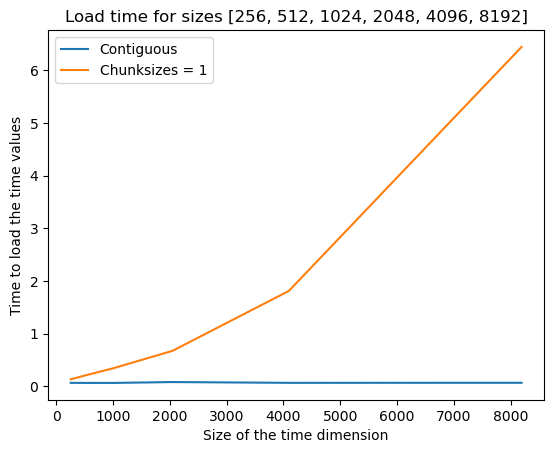

In [8]:
plt.plot(sizes, results[0::2], label="Contiguous")
plt.plot(sizes, results[1::2], label="Chunksizes = 1")
plt.legend()
plt.xlabel("Size of the time dimension")
plt.ylabel("Time to load the time values")
plt.title("Load time for sizes [256, 512, 1024, 2048, 4096, 8192]")